In [1]:
import re
import numpy as np
import pandas as pd

from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

import gensim.downloader as api

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping


In [2]:
# Load data
df = pd.read_csv('spam.csv') 

In [3]:
print(df.head())

  label                                               text
0   ham  Go until jurong point, crazy.. Available only ...
1   ham                      Ok lar... Joking wif u oni...
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...
3   ham  U dun say so early hor... U c already then say...
4   ham  Nah I don't think he goes to usf, he lives aro...


In [4]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   5572 non-null   object
 1   text    5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB
None


In [5]:
df['label'].value_counts()

label
ham     4825
spam     747
Name: count, dtype: int64

In [6]:
# lower case
def lower_case(text):
    return text.lower()

In [7]:
# remove HTML tags
def remove_html_tags(text):
    clean = re.compile('<.*?>')
    return re.sub(clean, '', text)

In [8]:
# remove stopwords
def remove_stopwords(text):
    stop_words = set(stopwords.words('english'))
    return ' '.join([word for word in text.split() if word not in stop_words])

In [9]:
# remove Numbers
def remove_num(text):
    return re.sub(r'[0-9]', '', text)

In [10]:
# remove extra spaces
def remove_extraspaces(text):
    return re.sub(r'\s+', ' ', text)

In [11]:
# stemming
def stemming(text):
    stemmer = PorterStemmer()
    return ' '.join([stemmer.stem(word) for word in text.split()])

In [12]:
# Apply text preprocessing functions
df['text'] = df['text'].apply(lower_case)
df['text'] = df['text'].apply(remove_html_tags)
df['text'] = df['text'].apply(remove_stopwords)
df['text'] = df['text'].apply(remove_num)
df['text'] = df['text'].apply(remove_extraspaces)
df['text'] = df['text'].apply(stemming)

In [13]:
label_map = {'ham': 0, 'spam': 1}
df['label'] = df['label'].map(label_map)

In [16]:
X_train, X_test, y_train, y_test = train_test_split(df['text'], df['label'], test_size=0.2, random_state=42)

In [17]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

In [18]:
# Pad sequences
max_len = 100
X_train_seq = pad_sequences(tokenizer.texts_to_sequences(X_train), maxlen=max_len)
X_test_seq = pad_sequences(tokenizer.texts_to_sequences(X_test), maxlen=max_len)

In [19]:
word_vectors = api.load("glove-wiki-gigaword-100")

In [20]:
embedding_matrix = np.zeros((len(tokenizer.word_index) + 1, 100))
for word, i in tokenizer.word_index.items():
    if word in word_vectors:
        embedding_matrix[i] = word_vectors[word]

In [21]:
# Build model
model = Sequential()
model.add(Embedding(len(tokenizer.word_index) + 1, 100, weights=[embedding_matrix], input_length=max_len, trainable=False))
model.add(LSTM(128, dropout=0.35, recurrent_dropout=0.3, return_sequences=True)) 
model.add(LSTM(64, dropout=0.35, recurrent_dropout=0.3)) 
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

c:\Users\Lenovo pc\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [22]:
# Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)

In [23]:
# Model Summary
print(model.summary())

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │       669,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 669,800 (2.56 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 669,800 (2.56 MB)

None


In [24]:
# Train model
history = model.fit(X_train_seq, y_train, batch_size=32, epochs=20, validation_split=0.25, callbacks=[early_stopping])

Epoch 1/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 15s 83ms/step - accuracy: 0.8604 - loss: 0.3882 - val_accuracy: 0.9578 - val_loss: 0.1410
Epoch 2/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 7s 71ms/step - accuracy: 0.9485 - loss: 0.1628 - val_accuracy: 0.9632 - val_loss: 0.1137
Epoch 3/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 7s 70ms/step - accuracy: 0.9697 - loss: 0.1029 - val_accuracy: 0.9641 - val_loss: 0.1085
Epoch 4/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 7s 71ms/step - accuracy: 0.9596 - loss: 0.1158 - val_accuracy: 0.9668 - val_loss: 0.1015
Epoch 5/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 8s 71ms/step - accuracy: 0.9691 - loss: 0.0944 - val_accuracy: 0.9668 - val_loss: 0.0986
Epoch 6/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 9s 88ms/step - accuracy: 0.9710 - loss: 0.0870 - val_accuracy: 0.9731 - val_loss: 0.0864
Epoch 7/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 8s 79ms/step - accuracy: 0.9727 - loss: 0.0827 - val_accuracy: 0.9713 - val_loss: 0.0844
Epoch 8/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 8s 74ms/step - accuracy: 0.9738 - loss: 0.0776 - val_acc

In [25]:
_, accuracy = model.evaluate(X_test_seq, y_test)
print('Accuracy:', accuracy)

35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.9849 - loss: 0.0679
Accuracy: 0.9838564991950989


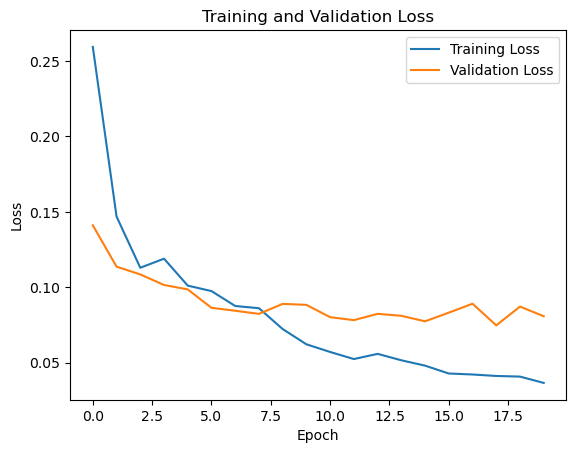

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_recall_curve

# plot training and validation loss
def plot_loss(history):
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
plot_loss(history)

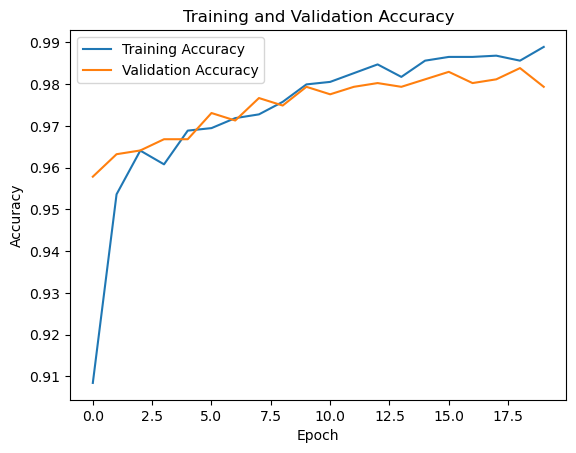

In [27]:
# plot training and validation accuracy
def plot_accuracy(history):
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()
plot_accuracy(history)

140/140 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step


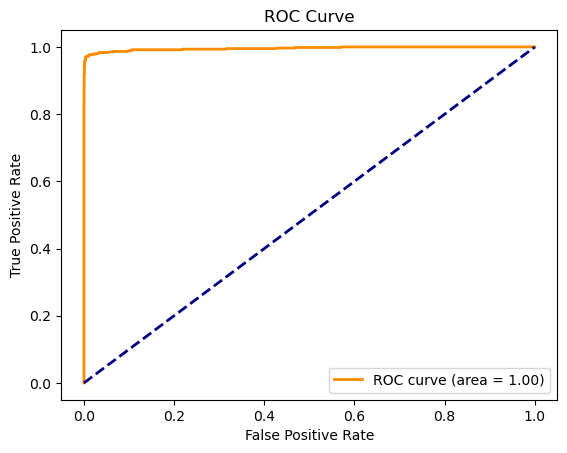

In [29]:
# plot ROC curve
def plot_roc_curve(model, X, y_true):
    y_pred = model.predict(X)
    fpr, tpr, _ = roc_curve(y_true, y_pred)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')
    plt.show()
plot_roc_curve(model, X_train_seq, y_train)

140/140 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step


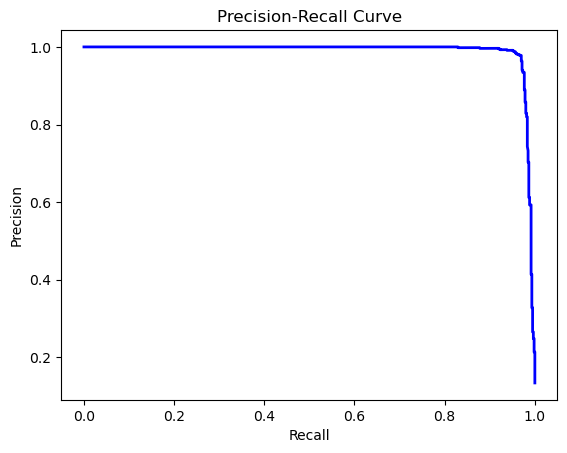

In [30]:
# plot Precision-Recall curve
def plot_precision_recall_curve(model, X, y_true):
    y_pred = model.predict(X)
    precision, recall, _ = precision_recall_curve(y_true, y_pred)
    plt.plot(recall, precision, color='blue', lw=2)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.show()
plot_precision_recall_curve(model, X_train_seq, y_train)